# Bibliothèques  <a class="anchor" id="prepare"></a>

In [82]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.applications import ResNet50, VGG16, Xception,InceptionV3,InceptionResNetV2
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from keras.applications.xception import preprocess_input as preprocess_xception
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception_resnet_v2
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
#from keras.metrics import accuracy

from tensorflow.nn import sigmoid_cross_entropy_with_logits
import tensorflow as tf

listdir("../input/")

['keras-pretrained-models', 'rsna-intracranial-hemorrhage-detection']

In [83]:
listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection")

['stage_2_train',
 'stage_2_sample_submission.csv',
 'stage_2_test',
 'stage_2_train.csv']

 ## Chemins du model gardé

In [84]:
MODELOUTPUT_PATH_BRUTE_FORCE = "bruteforce_best_model.hdf5"
brute_force_model_input = "../input/rsna-ih-detection-baseline-models/_bruteforce_best_model.hdf5"
brute_force_losses_path = "../input/rsna-ih-detection-baseline-models/brute_force_losses.csv"


# **Les lignes de base**

# **Prétraitement** 

Avant de  construire un modèle de deep learning, il faut configurer un dataloader (chargeur de données) et un préprocesseur d'image. On va utiliser Keras.

Le plan est le suivant :

- Lire l'ensemble de données dicom d'une image dicom brute
- Choix d'une fenêtre spécifique (Windowing) pour nous débarrasser des informations de l'image dont nous n'avons pas besoin.
- vérifier que toutes les images ont la même dimension. 
- Nous assurer que la forme de l'image correspond à celle attendue par notre modèle.

In [85]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

class Preprocessor:    
    
    def __init__(self, path, backbone, hu_min_value, hu_max_value, augment=False):
        self.path = path
        self.backbone = backbone
        self.nn_input_shape = backbone["nn_input_shape"]
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
        
    # 1. Charger les images dicom
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    # 2. Redimensionner les pixelarray en unités Hounsfield
     # et definir une fenêtre personnalisée:
    def get_hounsfield_window(self, dataset, min_value, max_value):
        try:
            hu_image = rescale_pixelarray(dataset)
            windowed_image = set_manual_window(hu_image, min_value, max_value)
        except ValueError:
           
            windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
        return windowed_image
        
    
    # 3. Redimensionner l'image à la forme d'entrée de notre CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image
    
    # 4. Augmentation de données
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5

**Dataloader (Chargeur de données personnalisé)**

Dataloader personalisé car notre prétraitement est personalisé.

In [86]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # Defini le nombre d'etape par epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # a la fin d'une epoch: 
    def on_epoch_end(self):
        # Si steps est "None" et shuffle is "Vrai":
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # Retourne un lot d'images
    def __getitem__(self, item):
        
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    #Collecter les images prétraitées et les cibles d'un lot
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            y[idx] = self.__get_target(ident)
        return X, y
    
    # Extraire les cibles d'un identifiant d'image
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

* ## Preparation des données <a class="anchor" id="dataframeprep"></a>

In [87]:
listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection")

['stage_2_train',
 'stage_2_sample_submission.csv',
 'stage_2_test',
 'stage_2_train.csv']

In [88]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_dir = INPUT_PATH + "stage_2_train/"
test_dir = INPUT_PATH + "stage_2_test/"

In [89]:
submission = pd.read_csv(INPUT_PATH + "stage_2_sample_submission.csv")
submission.head(7)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5


In [90]:
traindf = pd.read_csv(INPUT_PATH + "stage_2_train.csv")
traindf.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [91]:
label = traindf.Label.values
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
traindf.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [92]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_0fbf6a978,epidural,0
1,ID_0fbf6a978,intraparenchymal,0
2,ID_0fbf6a978,intraventricular,0
3,ID_0fbf6a978,subarachnoid,0
4,ID_0fbf6a978,subdural,0


**Nous devons avoir l'ID d'image dans une colonne et les sous-types d'hémorragie dans d'autres colonnes individuelles pour utiliser notre Dataloader.**

In [93]:
traindf = pd.pivot_table(traindf, index="id", columns="subtype", values="label")
traindf.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [94]:
testdf = pd.pivot_table(testdf, index="id", columns="subtype", values="label")
testdf.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0,0,0,0,0,0
ID_000009146,0,0,0,0,0,0
ID_00007b8cb,0,0,0,0,0,0
ID_000134952,0,0,0,0,0,0
ID_000176f2a,0,0,0,0,0,0


## Construire notre model <a class="anchor" id="buildbruteforce"></a>

Nous ajoutons quelques modeles pre-entraines à ce notebook 

In [95]:
pretrained_models_path = "../input/keras-pretrained-models/"
listdir("../input/keras-pretrained-models/")

['vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'Kuszma.JPG',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
 'imagenet_class_index.json',
 'xception_weights_tf_dim_ordering_tf_kernels.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [96]:
pretrained_models = {
    "resnet_50": {"weights": "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
                  "nn_input_shape": (224,224),
                  "preprocess_fun": preprocess_resnet_50},
    "vgg_16": {"weights": "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
              "nn_input_shape": (224,224),
              "preprocess_fun": preprocess_vgg_16},
    "xception": {"weights":"xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
                "nn_input_shape": (224,224),
                "preprocess_fun": preprocess_xception},
    "inception_v3" : {"weights": "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5",
                     "nn_input_shape": (224,224),
              "preprocess_fun": preprocess_inception_v3},
    "inception_resnet_v2": {"weights": 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  "nn_input_shape": (224,224),
                  "preprocess_fun": preprocess_inception_resnet_v2},
}

In [97]:
def resnet_50():
    weights_path = pretrained_models_path + pretrained_models["resnet_50"]["weights"]
    net = ResNet50(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

def vgg_16():
    weights_path = pretrained_models_path + pretrained_models["vgg_16"]["weights"]
    net = VGG16(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

def xception():
    weights_path = pretrained_models_path + pretrained_models["xception"]["weights"]
    net = Xception(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

def inception_v3():
    weights_path = pretrained_models_path + pretrained_models["inception_v3"]["weights"]
    net = InceptionV3(weights=weights_path, include_top=False)
    for layer in net.layers:
        layer.trainable = False
    return net

def inception_resnet_v2():
    weights_path = pretrained_models_path + pretrained_models["inception_resnet_v2"]["weights"]
    net = InceptionResNetV2(weights=weights_path,include_top=False)
    for layer in net.layers:
        layer.trainable = False
    return net

**Notre modele personalisé**

-Definition de notre reseau
-Definition des fonctions: contruction, compilation et apprentissage du modele


In [98]:
class MyNetwork:
    
    def __init__(self,
                 model_fun,
                 loss_fun,
                 metrics_list,
                 train_generator,
                 dev_generator,
                 epochs,
                 num_classes=6,
                 checkpoint_path=MODELOUTPUT_PATH_BRUTE_FORCE):
        self.model_fun = model_fun
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.train_generator = train_generator
        self.dev_generator = dev_generator
        self.epochs = epochs
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
   # Contruction de modele      
    def build_model(self):
        base_model = self.model_fun()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        pred = Dense(self.num_classes,
                     kernel_initializer=he_normal(seed=11),
                     kernel_regularizer=l2(0.05),
                     bias_regularizer=l2(0.05), activation="sigmoid")(x)
        self.model = Model(inputs=base_model.input, outputs=pred)
    # Compilation du modele
    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=LR),
                           loss=self.loss_fun, 
                           metrics=self.metrics_list)
    #Apprentissage du modele
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.dev_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    use_multiprocessing=False,
                    workers=8)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, test_generator):
        predictions = self.model.predict_generator(test_generator, workers=8)
        return predictions

### Donées de Validation 


In [99]:
split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed).split(np.arange(traindf.shape[0]), traindf["any"].values)

train_idx, dev_idx = next(kfold)

train_data = traindf.iloc[train_idx]
dev_data = traindf.iloc[dev_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)

(602242, 6)
(150561, 6)


**D'autre fonctions perte importées **

In [100]:
def np_multilabel_loss(y_true, y_pred, class_weights=None):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

def get_raw_xentropies(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    xentropies = y_true * tf.log(y_pred) + (1-y_true) * tf.log(1-y_pred)
    return -xentropies

# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0 
def multilabel_focal_loss(class_weights=None, alpha=0.5, gamma=2):
    def mutlilabel_focal_loss_inner(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        xentropies = get_raw_xentropies(y_true, y_pred)

        # compute pred_t:
        y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))

        # compute focal loss contributions
        focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t) 

        # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
        focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

        # compute the overall loss if class weights are None (equally weighted):
        if class_weights is None:
            focal_loss_result = tf.reduce_mean(focal_loss_per_class)
        else:
            # weight the single class losses and compute the overall loss
            weights = tf.constant(class_weights, dtype=tf.float32)
            focal_loss_result = tf.reduce_sum(tf.multiply(weights, focal_loss_per_class))
            
        return focal_loss_result
    return mutlilabel_focal_loss_inner

## Choix des parametres du modele à entrainer

In [101]:
BACKBONE = "vgg_16" # Apprentissage par transfert, modele pre entrainé utilisé
BATCH_SIZE = 16 # Taille du lot
TEST_BATCH_SIZE = 5
MIN_VALUE = 0
MAX_VALUE = 90
STEPS = 50
EPOCHS = 10

LR = 0.001 # Learning Rate ( pas d'apprentissage)

**Prétraitement des images de formation et de validation** 

In [102]:
train_preprocessor = Preprocessor(path=train_dir,
                                  backbone=pretrained_models[BACKBONE],
                                  hu_min_value=MIN_VALUE,
                                  hu_max_value=MAX_VALUE,
                                  augment=True)

dev_preprocessor = Preprocessor(path=train_dir,
                                backbone=pretrained_models[BACKBONE],
                                hu_min_value=MIN_VALUE,
                                hu_max_value=MAX_VALUE,
                                augment=False)


**Chargement des images de formation et de validation prétraitées **

In [103]:
train_dataloader = DataLoader(train_data,
                              train_preprocessor,
                              BATCH_SIZE,
                              shuffle=True,
                              steps=STEPS)

dev_dataloader = DataLoader(dev_data, 
                            dev_preprocessor,
                            BATCH_SIZE,
                            shuffle=True,
                            steps=STEPS)



**Affectation du poid 0.1 aux 5 classes de l'IH et 0.5 à la classe "any" (qui est activée quand au minimum une des 5 classe de l'IH  est activée**

In [104]:
my_class_weights = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]

**Construction de notre modele **

In [105]:
model = MyNetwork(model_fun=inception_v3,
                      loss_fun="binary_crossentropy",#multilabel_focal_loss(class_weights=my_class_weights, alpha=0.5, gamma=0)
                      metrics_list=[categorical_accuracy,], #multilabel_focal_loss(alpha=0.5, gamma=0)],
                      train_generator=train_dataloader,
                      dev_generator=dev_dataloader,
                      epochs=EPOCHS,
                      num_classes=6)

model.build_model()

**Compilation de notre modele**

In [106]:
model.compile_model()

**************************Apprentissage du modele

In [107]:
history = model.learn()

Epoch 1/10
50/51 [============================>.] - ETA: 0s - loss: 0.8565 - categorical_accuracy: 0.6425
Epoch 00001: val_loss improved from inf to 0.68325, saving model to bruteforce_best_model.hdf5
51/51 [==============================] - 27s 521ms/step - loss: 0.8545 - categorical_accuracy: 0.6446 - val_loss: 0.6833 - val_categorical_accuracy: 0.9963
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 0.6319 - categorical_accuracy: 0.7659
Epoch 00002: val_loss improved from 0.68325 to 0.54136, saving model to bruteforce_best_model.hdf5
51/51 [==============================] - 26s 508ms/step - loss: 0.6319 - categorical_accuracy: 0.7659 - val_loss: 0.5414 - val_categorical_accuracy: 0.9988
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.4898 - categorical_accuracy: 0.8542
Epoch 00003: val_loss improved from 0.54136 to 0.44355, saving model to bruteforce_best_model.hdf5
51/51 [==============================] - 25s 483ms/step - loss: 0.4898 - cate

**Afficher les parametres enregistres lors de l'apprentissage **

In [108]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


**Afficher larchitecture du modele **

In [109]:
print(model.model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, None, None, 3 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, None, None, 3 0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

activation_456 (Activation)     (None, None, None, 4 0           batch_normalization_456[0][0]    
__________________________________________________________________________________________________
conv2d_453 (Conv2D)             (None, None, None, 3 491520      mixed8[0][0]                     
__________________________________________________________________________________________________
conv2d_457 (Conv2D)             (None, None, None, 3 1548288     activation_456[0][0]             
__________________________________________________________________________________________________
batch_normalization_453 (BatchN (None, None, None, 3 1152        conv2d_453[0][0]                 
__________________________________________________________________________________________________
batch_normalization_457 (BatchN (None, None, None, 3 1152        conv2d_457[0][0]                 
__________________________________________________________________________________________________
activation

> Total params: 22,008,290

> Trainable params: 205,506

> Non-trainable params: 21,802,784

**Définition des polices pour les differents affichages**

In [110]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

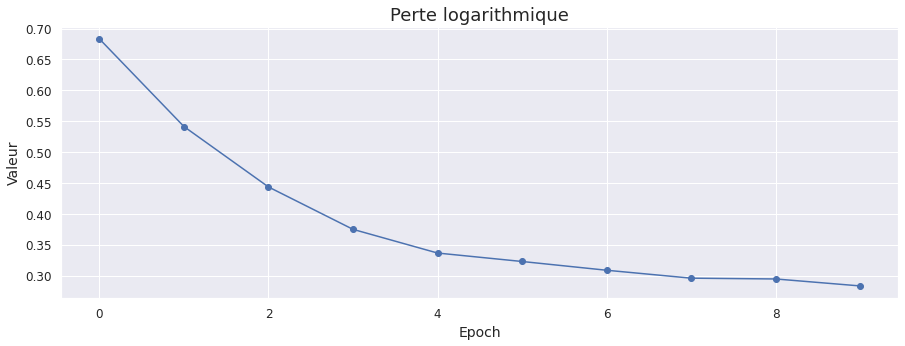

In [111]:
fig=plt.figure(figsize=(15, 5))
plt.plot(history.history["val_loss"], 'o-')
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.title("Perte logarithmique");

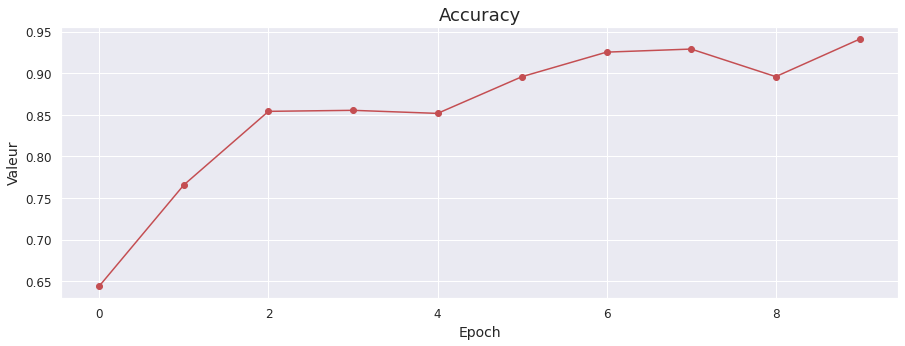

In [112]:
fig=plt.figure(figsize=(15, 5))
plt.plot(history.history["categorical_accuracy"], 'ro-')
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.title("Accuracy");

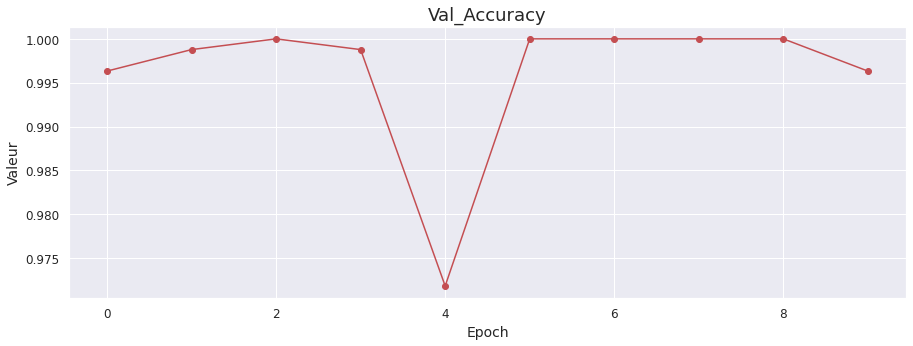

In [113]:
fig=plt.figure(figsize=(15, 5))
plt.plot(history.history["val_categorical_accuracy"], 'ro-')
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.title("Val_Accuracy");

Text(0.5, 1.0, 'Accuracy')

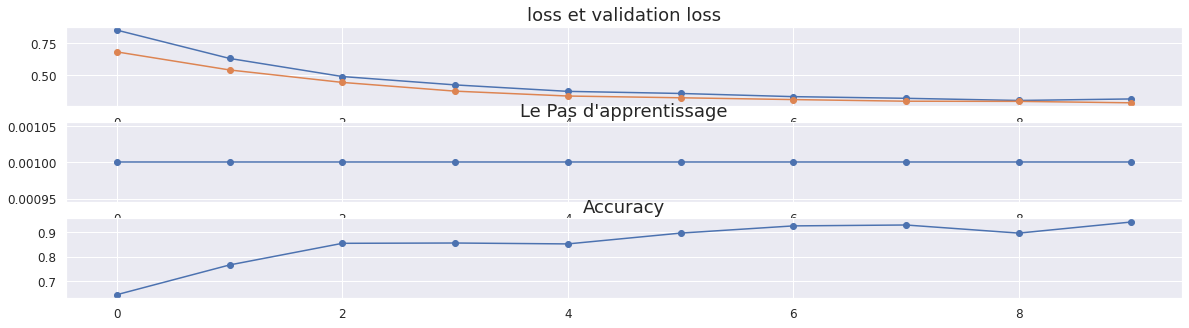

In [114]:
fig, ax = plt.subplots(3,1,figsize=(20,5))
ax[0].plot(history.history["loss"], 'o-')
ax[0].plot(history.history["val_loss"], 'o-')
ax[0].set_title("loss et validation loss")
ax[1].plot(history.history["lr"], 'o-')
ax[1].set_title("Le Pas d'apprentissage")
ax[2].plot(history.history["categorical_accuracy"], 'o-')
ax[2].set_title("Accuracy")